<a href="https://www.kaggle.com/code/ryanglasnapp/sakura-predictions?scriptVersionId=93457098" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Introduction
The model in this notebook is based on *Deep learning for time series classification: a review* by Ismail Fawaz, Hassan and Forestier, Germain and Weber, Jonathan and Idoumghar, Lhassane and Muller, and Pierre-Alain.

See the References sections at the bottom for further detail. 

Work in Progress: Any comments or suggestions are appreciated.


TODO: (Reminders of things I need to do).
* Take unbatch code and filtering of the testset dataset and apply it to the sakura data. Then balance the datasets, recombine them, and see if *that* fixes the nan issue.

## Data Loading and Cleaning

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow.keras as keras
import sklearn

In [2]:
!pip install july

import july
from july.utils import date_range



### Data Testing
Doing some basic testing with a small subset of data.

In [3]:
city_subset_list = ['Kyoto', 'Osaka','Nara']
city_subset = {}

for city in city_subset_list:
    # Note: Individual is not spelled correctly in the dataset, whoops.
    city_subset[city] = pd.read_csv(f'../input/japanese-temperature-data/individal_cities/{city}.csv', parse_dates=[0])
    city_subset[city].set_index('Date',inplace=True)
    
first_bloom = pd.read_csv('../input/japanese-cherry-blossom-data/sakura_first_bloom_dates.csv')
full_bloom = pd.read_csv('../input/japanese-cherry-blossom-data/sakura_full_bloom_dates.csv')


first_bloom.set_index('Site Name', inplace=True)
full_bloom.set_index('Site Name', inplace=True)

In [4]:
# Cleaning
city_subset['Kyoto'].columns = city_subset['Kyoto'].columns.str.replace('.* Avg Temp','Avg Temp')

city_subset['Kyoto']['Avg Temp'].interpolate(inplace=True)


# Adding some features (in case I decide to fiddle with them later)
city_subset['Kyoto'].loc[:,'7 day mean'] = city_subset['Kyoto'].loc[:,'Avg Temp'].rolling(7).mean()
city_subset['Kyoto'].loc[:,'14 day mean'] = city_subset['Kyoto'].loc[:,'Avg Temp'].rolling(14).mean()
city_subset['Kyoto'].loc[:,'28 day mean'] = city_subset['Kyoto'].loc[:,'Avg Temp'].rolling(28).mean()

# Adding in the predictors
city_subset['Kyoto'].loc[:,'Bloom Status'] = 0
for col in first_bloom:
    if str.isnumeric(col):
        if col >= '1955' and col <= '2018':
            city_subset['Kyoto'].loc[first_bloom.loc['Kyoto', col]:full_bloom.loc['Kyoto', col],'Bloom Status'] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


Math for posterity:

Original form for End of a batch:
batch_idx * batch_size * stride + (batch_size - 1)* stride + length

Simplified:
(batch_idx + 1)* batch_sz * stride - stride + length


Size of the data before batching should be such that for any integer n:

data_size = (n * batch_size-1)* stride + length 

So:

require: (data_size - length)/stride + 1 % batch_size == 0 

In [5]:
length = 28
stride = 14
batch_sz = 16
batch_len = length + (batch_sz - 1)*stride
train_pct = 0.70

train_max_points = int(city_subset['Kyoto'].loc[:,'Avg Temp'].shape[0] * train_pct)
train_num_batches = ((train_max_points - length)/stride + 1 ) // batch_sz
train_sz = int((train_num_batches * batch_sz - 1)*stride + length)
train_end_date = city_subset['Kyoto'].index[train_sz - 1]

test_max_points = city_subset['Kyoto'].loc[train_end_date:,'Avg Temp'].shape[0] 
test_num_batches = ((test_max_points - length)/stride + 1 ) // batch_sz
test_sz = int((test_num_batches * batch_sz - 1)*stride + length)
test_end_date = city_subset['Kyoto'].index[train_sz+test_sz - 2]

X_train = city_subset['Kyoto'].loc[:train_end_date,'Avg Temp']
y_train = city_subset['Kyoto'].loc[:train_end_date,'Bloom Status'].shift(-length+1, fill_value=0).rolling(length).max()
y_train.fillna(0, inplace=True)

X_test = city_subset['Kyoto'].loc[train_end_date:test_end_date,'Avg Temp']
y_test = city_subset['Kyoto'].loc[train_end_date:test_end_date,'Bloom Status'].shift(-length+1, fill_value=0).rolling(length).max()

# Note for future self: Use end_index to split this into a training set and validation set, as well as contraining things to clean multiples of the batch size
dataset = tf.keras.utils.timeseries_dataset_from_array(X_train, y_train, sequence_length=length, sequence_stride=stride, batch_size=batch_sz)
dataset_test = tf.keras.utils.timeseries_dataset_from_array(X_test, y_test, sequence_length=length, sequence_stride=stride, batch_size=batch_sz)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [6]:
n=1
s=(n-1)*104-1
f=n*104-1
y_train[s*stride+28:f*stride+28].tail(28)

Date
1958-12-13    0.0
1958-12-14    0.0
1958-12-15    0.0
1958-12-16    0.0
1958-12-17    0.0
1958-12-18    0.0
1958-12-19    0.0
1958-12-20    0.0
1958-12-21    0.0
1958-12-22    0.0
1958-12-23    0.0
1958-12-24    0.0
1958-12-25    0.0
1958-12-26    0.0
1958-12-27    0.0
1958-12-28    0.0
1958-12-29    0.0
1958-12-30    0.0
1958-12-31    0.0
1959-01-01    0.0
1959-01-02    0.0
1959-01-03    0.0
1959-01-04    0.0
1959-01-05    0.0
1959-01-06    0.0
1959-01-07    0.0
1959-01-08    0.0
1959-01-09    0.0
Name: Bloom Status, dtype: float64

In [7]:
list(dataset.as_numpy_iterator())[0][1][6]
#city_subset['Kyoto'].index[batch_len*1 - 1]


2022-04-19 16:06:00.416650: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1.0

The following model is from *Deep learning for time series classification: a review* by Ismail Fawaz, Hassan and Forestier, Germain and Weber, Jonathan and Idoumghar, Lhassane and Muller, and Pierre-Alain.

In [8]:
def build_model(input_shape, batch_size, nb_classes):
    n_feature_maps = 64

    input_layer = keras.layers.Input(input_shape,batch_size=batch_size)

    # BLOCK 1

    conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)

    # BLOCK 2

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)

    # BLOCK 3

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)

    # FINAL

    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

    output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy'])

    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)

    return model

In [9]:
resnet = build_model((28,1), batch_sz, 1)

#resnet.summary()

In [10]:
print(y_train.value_counts())

# This is not the correct way to do the weights. I should be basing these class weights on the actual values in the batched datasets, but I'm not quite sure 
# how to properly unwrap that yet. (And this should be approximately correct)

class_labels = np.unique(y_train)
class_weight = sklearn.utils.class_weight.compute_class_weight('balanced', classes=class_labels, y=y_train.to_numpy())
#class_weights = dict( zip(class_labels, class_weight) )
class_weights = dict(enumerate(class_weight))
print(class_weights)

0.0    15214
1.0     1600
Name: Bloom Status, dtype: int64
{0: 0.552583147101354, 1: 5.254375}


In [11]:
data_iter = iter(dataset)
#input, output = data_iter.get_next()
#input_shape = input.shape

#for input, output in data_iter:
#    resnet.fit(input, output, batch_size=batch_sz, epochs=4, class_weight=class_weights, validation_data=dataset_test, validation_steps=4)
    
resnet.fit(dataset, batch_size=batch_sz, epochs=4, class_weight=class_weights, validation_data=dataset_test)

Epoch 1/4
75/75 [==============================] - 9s 67ms/step - loss: 0.0000e+00 - accuracy: 0.0942 - val_loss: nan - val_accuracy: 0.0898
Epoch 2/4
75/75 [==============================] - 4s 54ms/step - loss: 0.0000e+00 - accuracy: 0.0942 - val_loss: nan - val_accuracy: 0.0898
Epoch 3/4
75/75 [==============================] - 4s 55ms/step - loss: 0.0000e+00 - accuracy: 0.0942 - val_loss: nan - val_accuracy: 0.0898
Epoch 4/4
75/75 [==============================] - 4s 55ms/step - loss: 0.0000e+00 - accuracy: 0.0942 - val_loss: nan - val_accuracy: 0.0898


# Visualizations

In [12]:
resnet.predict(city_subset['Kyoto'].loc['2010-01-01':'2015-12-31','Avg Temp'])

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [13]:
dates = date_range("2015-01-01", "2015-12-31")


<AxesSubplot:>

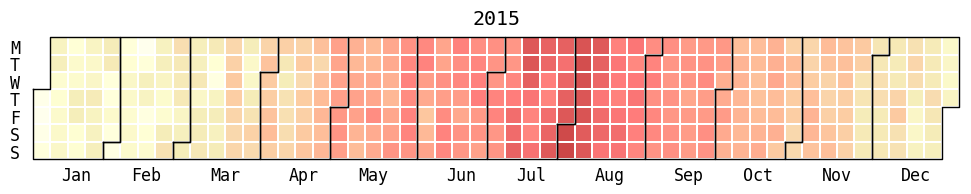

In [14]:
july.heatmap(dates, city_subset['Kyoto'].loc['2015-01-01':'2015-12-31','Avg Temp'], month_grid=True)

## Testing
This is a collection of some old cells that I'm keeping out of the way in case I need them again for testing.

In [15]:

def isinfinite(df):
    print(df[np.isfinite(df).all(1)])

isinfinite(city_subset['Kyoto'])

            Avg Temp  Data Quality tn  Data Homogeneity tn  7 day mean  \
Date                                                                     
1955-01-28       3.0                8                    1    4.157143   
1955-01-29       6.5                8                    1    4.242857   
1955-01-30       6.4                8                    1    4.500000   
1955-01-31       4.9                8                    1    4.485714   
1955-02-01       2.8                8                    1    4.157143   
...              ...              ...                  ...         ...   
2020-12-28       8.4                8                    1    6.400000   
2020-12-29       7.8                8                    1    6.757143   
2020-12-30       6.9                8                    1    6.900000   
2020-12-31       2.1                8                    1    6.357143   
2021-01-01       2.1                8                    1    5.728571   

            14 day mean  28 day mean 

In [16]:
y_train.head(32)

#city_subset['Kyoto'].loc[:'1955-02-01','Bloom Status'].shift(-length).rolling(length).max()
city_subset['Kyoto'].loc[:'1955-05-01','Bloom Test'] = city_subset['Kyoto'].loc[:'1955-05-01','Bloom Status'].shift(-length+1, fill_value=0).rolling(length).max()

city_subset['Kyoto'].loc['1955-03-01':'1955-04-28',['Bloom Test', 'Bloom Status']].head(28)

,Bloom Test,Bloom Status
Date,,
1955-03-01,1.0,0
1955-03-02,1.0,0
1955-03-03,1.0,0
1955-03-04,1.0,0
1955-03-05,1.0,0
1955-03-06,1.0,0
1955-03-07,1.0,0
1955-03-08,1.0,0
1955-03-09,1.0,0


In [17]:
(np.linspace(0,199,200)%9==0).astype(int)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0])

In [18]:
datatest = tf.keras.utils.timeseries_dataset_from_array(np.linspace(0,199,200), (np.linspace(0,199,200)%9==0).astype(int), sequence_length=10, sampling_rate=1, sequence_stride=5, batch_size=4)
for testset in iter(datatest):
   print(testset)
    


(<tf.Tensor: shape=(4, 10), dtype=float64, numpy=
array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
       [ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.],
       [10., 11., 12., 13., 14., 15., 16., 17., 18., 19.],
       [15., 16., 17., 18., 19., 20., 21., 22., 23., 24.]])>, <tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 0, 0, 0])>)
(<tf.Tensor: shape=(4, 10), dtype=float64, numpy=
array([[20., 21., 22., 23., 24., 25., 26., 27., 28., 29.],
       [25., 26., 27., 28., 29., 30., 31., 32., 33., 34.],
       [30., 31., 32., 33., 34., 35., 36., 37., 38., 39.],
       [35., 36., 37., 38., 39., 40., 41., 42., 43., 44.]])>, <tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 0, 0, 0])>)
(<tf.Tensor: shape=(4, 10), dtype=float64, numpy=
array([[40., 41., 42., 43., 44., 45., 46., 47., 48., 49.],
       [45., 46., 47., 48., 49., 50., 51., 52., 53., 54.],
       [50., 51., 52., 53., 54., 55., 56., 57., 58., 59.],
       [55., 56., 57., 58., 59., 60., 61., 62., 63., 64.]])>, <tf

In [19]:
def filter_class_blossoms(x,y):
  return tf.math.equal(y, 1)

def filter_class_noblossoms(x,y):
  return tf.math.equal(y, 0)

def balance_dataset(dataset):
    dataset_unb = dataset.unbatch()
    dataset_blossoms = dataset_unb.filter(filter_class_blossoms)
    dataset_no_blossoms = dataset_unb.filter(filter_class_noblossoms)
    #print(list(dataset_blossoms.as_numpy_iterator()).shape)
    #print(tf.data.experimental.cardinality(dataset_blossoms).numpy())
    
    dataset_mixed = tf.data.experimental.sample_from_datasets( [dataset_blossoms, dataset_no_blossoms], stop_on_empty_dataset=True)
    #max_take = len( list(dataset_blossoms.as_numpy_iterator()) )
    #dataset_nb_short = dataset_no_blossoms.take(max_take)
    dataset_mixed = dataset_mixed.batch(batch_sz,drop_remainder=True)
    return dataset_mixed


Note for future self: The original test dataset only has 512 entries in it, which at first seems mismatched because of the ~7000 total datapoints, but it's also that 7000 broken up into chunks of 2 weeks, which fits. 

In [20]:
derpy_test = balance_dataset(dataset_test)
derpy = balance_dataset(dataset)

resnet.fit(derpy, batch_size=batch_sz, epochs=5, validation_data=derpy_test)


print(len(list(derpy.as_numpy_iterator())))
#for testset in iter(derpy.as_numpy_iterator()):
#   print(testset)

print(y_test.value_counts())


#list(dataset_test.as_numpy_iterator())
#tf.data.experimental.cardinality(dataset_test).numpy()

Epoch 1/5
12/12 [==============================] - 4s 155ms/step - loss: 0.0000e+00 - accuracy: 0.5781 - val_loss: 0.0000e+00 - val_accuracy: 0.5500
Epoch 2/5
12/12 [==============================] - 1s 100ms/step - loss: 0.0000e+00 - accuracy: 0.4583 - val_loss: 0.0000e+00 - val_accuracy: 0.5500
Epoch 3/5
12/12 [==============================] - 1s 97ms/step - loss: 0.0000e+00 - accuracy: 0.4635 - val_loss: 0.0000e+00 - val_accuracy: 0.5125
Epoch 4/5
12/12 [==============================] - 1s 99ms/step - loss: 0.0000e+00 - accuracy: 0.5260 - val_loss: 0.0000e+00 - val_accuracy: 0.6406
Epoch 5/5
12/12 [==============================] - 1s 71ms/step - loss: 0.0000e+00 - accuracy: 0.5312
12
0.0    6493
1.0     662
Name: Bloom Status, dtype: int64


In [21]:
y_pred = resnet.predict(city_subset['Kyoto'].loc['2010-01-01':'2015-12-31','Avg Temp'])

pd.DataFrame(y_pred).value_counts()

1.0    2191
dtype: int64

In [22]:
city_subset['Kyoto']['Avg Temp'].loc['1978-06-08':'1978-06-28']

Date
1978-06-08    22.900000
1978-06-09    23.500000
1978-06-10    23.900000
1978-06-11    20.300000
1978-06-12    24.300000
1978-06-13    21.900000
1978-06-14    23.400000
1978-06-15    25.800000
1978-06-16    25.142857
1978-06-17    24.485714
1978-06-18    23.828571
1978-06-19    23.171429
1978-06-20    22.514286
1978-06-21    21.857143
1978-06-22    21.200000
1978-06-23    21.400000
1978-06-24    23.400000
1978-06-25    24.300000
1978-06-26    26.600000
1978-06-27    26.000000
1978-06-28    23.700000
Name: Avg Temp, dtype: float64

In [23]:
#tf.data.Dataset.interleave()
(np.linspace(0,199,200)%9==0).astype(int)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0])

In [24]:
#for testset, derp in iter(datatest_unb):
#    print(testset)
#    print(derp)

In [25]:
idx = 7
#X.iloc[14*idx:14*idx+28]
city_subset['Kyoto'].loc[:,['Avg Temp','Bloom Status']].iloc[14*idx:14*idx+28]

,Avg Temp,Bloom Status
Date,,
1955-04-09,16.8,0
1955-04-10,16.9,0
1955-04-11,17.0,0
1955-04-12,17.8,0
1955-04-13,18.6,0
1955-04-14,19.5,0
1955-04-15,17.3,0
1955-04-16,18.1,0
1955-04-17,17.0,0


In [26]:
list(dataset_test.as_numpy_iterator())[-1][0].shape

(16, 28)

## References

@article{IsmailFawaz2018deep,
  Title                    = {Deep learning for time series classification: a review},
  Author                   = {Ismail Fawaz, Hassan and Forestier, Germain and Weber, Jonathan and Idoumghar, Lhassane and Muller, Pierre-Alain},
  journal                  = {Data Mining and Knowledge Discovery},
  Year                     = {2019},
  volume                   = {33},
  number                   = {4},
  pages                    = {917--963},
}


### 